In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

In [0]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 100
batch_size = 128


seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [8]:
with open('/content/drive/My Drive/data_batch_1', 'rb') as db:
    try:
        train_samples = pickle.load(db)
    except UnicodeDecodeError:  #python 3.x
        db.seek(0)
        train_samples = pickle.load(db, encoding='latin1')

trainX, trainY = train_samples['data'], train_samples['labels']

trainX = np.array(trainX, dtype=np.float32)
trainY = np.array(trainY, dtype=np.int32)
    
trainY_ = np.zeros([trainY.shape[0], NUM_CLASSES])
trainY_[np.arange(trainY.shape[0]), trainY-1] = 1

print(trainX.shape, trainY_.shape)



(10000, 3072) (10000, 10)


In [9]:
with open('/content/drive/My Drive/test_batch_trim', 'rb') as tb:
    try:
        test_samples = pickle.load(tb)
    except UnicodeDecodeError:  #python 3.x
        tb.seek(0)
        test_samples = pickle.load(tb, encoding='latin1')
        
testX, testY = test_samples['data'], test_samples['labels']

testX = np.array(testX, dtype=np.float32)
testY = np.array(testY, dtype=np.int32)
    
testY_ = np.zeros([testY.shape[0], NUM_CLASSES])
testY_[np.arange(testY.shape[0]), testY-1] = 1

print(testX.shape, testY_.shape)

(2000, 3072) (2000, 10)


Training with 5 feature maps at conv1 and  5 feature maps at conv2
Test Accuracy for 5 and 5 is 0.248
Best test accuracy after search is 5 and 5 with accuracy 0.248
Training with 5 feature maps at conv1 and  10 feature maps at conv2
Test Accuracy for 5 and 10 is 0.3095
Best test accuracy after search is 5 and 10 with accuracy 0.3095
Training with 5 feature maps at conv1 and  15 feature maps at conv2
Test Accuracy for 5 and 15 is 0.3345
Best test accuracy after search is 5 and 15 with accuracy 0.3345
Training with 5 feature maps at conv1 and  20 feature maps at conv2
Test Accuracy for 5 and 20 is 0.3185
Best test accuracy after search is 5 and 15 with accuracy 0.3345
Training with 5 feature maps at conv1 and  25 feature maps at conv2
Test Accuracy for 5 and 25 is 0.3285
Best test accuracy after search is 5 and 15 with accuracy 0.3345
Training with 5 feature maps at conv1 and  30 feature maps at conv2
Test Accuracy for 5 and 30 is 0.352
Best test accuracy after search is 5 and 30 with ac

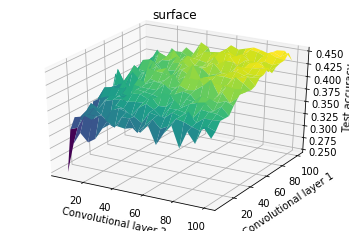

In [10]:
trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)
testX = (testX - np.min(testX, axis = 0))/np.max(testX, axis = 0)

 # Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

images = x
images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

max_test_acc = 0
max_map1 = 0
max_map2 = 0
test_acc = []

for map1 in range(5,101,5):
    for map2 in range(5,101,5):
        print("Training with", map1, "feature maps at conv1 and ", map2, "feature maps at conv2")
    
        #Conv 1 -- maps one RGB image (3x32x32) to map1 feature maps (map1x24x24), pool to (map1x12x12)
        W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, map1], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
        b1 = tf.Variable(tf.zeros([map1]), name='biases_1')

        conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
        pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

        #Conv 2 -- maps map1 feature maps (map1x12x12) to map2 (map2x8x8), pool to (map2x4x4)
        W2 = tf.Variable(tf.truncated_normal([5, 5, map1, map2], stddev=1.0/np.sqrt(NUM_CHANNELS*5*5)), name='weights_2')
        b2 = tf.Variable(tf.zeros([map2]), name='biases_2')

        conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1,1,1,1,], padding='VALID')+ b2)
        pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

        #Fully Connected Layer -- maps map2 feature maps (map2x4x4) to 300 features
        pool_2_shape = pool_2.get_shape().as_list()
        dim = pool_2_shape[1] * pool_2_shape[2] * pool_2_shape[3]
        reshape = tf.reshape(pool_2, [-1, dim])

        W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
        b3 = tf.Variable(tf.zeros([300]), name='biases_3')

        fcon = tf.nn.relu(tf.matmul(reshape, W3) + b3)

        #Softmax
        W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), name='weights_4')
        b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')
        logits = tf.matmul(fcon, W4) + b4

        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
        loss = tf.reduce_mean(cross_entropy)

        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)

        N = len(trainX)
        idx = np.arange(N)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for e in range(epochs):
                np.random.shuffle(idx)
                trainX, trainY_ = trainX[idx], trainY_[idx]
        
                for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                    train_step.run(feed_dict={x: trainX[start:end], y_: trainY_[start:end]})
            
            acc = accuracy.eval(feed_dict={x: testX, y_: testY_}) 
            test_acc = np.append(test_acc,acc)
        
            if (acc > max_test_acc):
                max_test_acc = acc
                max_map1 = map1
                max_map2 = map2
                    
            print('Test Accuracy for', map1, 'and', map2, 'is', acc)        
            print('Best test accuracy after search is', max_map1, 'and', max_map2, 'with accuracy', max_test_acc)

from mpl_toolkits import mplot3d
x = range(5,101,5)
y = range(5,101,5)
X,Y = np.meshgrid(x,y)
test_acc = test_acc.reshape((20,20))
print(test_acc)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_surface(X, Y, test_acc, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.set_xlabel('Convolutional layer 2')
ax.set_ylabel('Convolutional layer 1')
ax.set_zlabel('Test accuracy');
plt.savefig('A2-test-accuracy')